<a href="https://colab.research.google.com/github/carlos-alves-one/-AI-Coursework-2/blob/main/glaucoma_detection_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Goldsmiths University of London
### MSc. Data Science and Artificial Intelligence
### Module: Artificial Intelligence
### Author: Carlos Manuel De Oliveira Alves
### Student: cdeol003
### Coursework No.2

#Project
VisionGuard AI: Deep Learning for Early Glaucoma Detection

# Introduction

The purpose of this research is to outline the progression of a deep-learning model designed to identify glaucoma through the analysis of ocular pictures. Glaucoma is a debilitating ocular disorder that, if left undetected and untreated in its early stages, can result in complete vision loss. Effective screening procedures are necessary due to the asymptomatic nature of the early stages of glaucoma. Deep learning, specifically convolutional neural networks (CNNs), has demonstrated considerable potential in image identification tasks and can aid in the early detection of glaucoma. The dataset utilised in this research comprises a collection of ocular pictures accompanied by a binary classification showing the presence or absence of glaucoma. The ExpCDR, or 'Cup to Disc Ratio', is a crucial clinical parameter utilised in evaluating glaucoma for each image.

# Methodology

## Data Preprocessing

The photos will undergo a process of loading, resizing to a consistent dimension, and normalisation to ensure that their pixel values fall within the range of 0 to 1. Furthermore, it is possible to employ data augmentation methods, such as rotations, shifts, and flips, in order to augment the size and diversity of the dataset. This can be beneficial in mitigating the issue of overfitting.

### Load the data

In [1]:
# Imports the 'drive' module from 'google.colab' and mounts the Google Drive to
# the '/content/drive' directory in the Colab environment.
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import the pandas library and give it the alias 'pd' for data manipulation and analysis
import pandas as pd

# Load the dataset glaucoma from Google Drive
data_path = '/content/drive/MyDrive/glaucoma.csv'
glaucoma_data = pd.read_csv(data_path)

# Display the first few rows of the dataframe
glaucoma_data.head()


,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0


Dataset source: https://www.kaggle.com/datasets/sshikamaru/glaucoma-detection

License: CC0 - Public Domain
https://creativecommons.org/publicdomain/zero/1.0/

The dataset contains the following columns:

    - Filename: The name of the image file.
    - ExpCDR: The 'Cup to Disc Ratio', a crucial parameter for evaluating glaucoma.
    - Eye: Indicates which eye the image corresponds to (OD for right eye, OS for left eye).
    - Set: This could denote the dataset split (e.g., training, validation, or test set), but we would need further clarification.
    - Glaucoma: The binary label indicating the presence (1) or absence (0) of glaucoma.

###Set a Random Seed

Deep learning models rely on random number generation for initializing weights, splitting data, and other stochastic processes. Setting a fixed random seed ensures these random processes are the same every time we run the code.# Import the NumPy library for numerical operations
import numpy as np

In [ ]:
# Import the NumPy library for numerical operations
import numpy as np

# Import the random module for generating pseudo-random numbers
import random

# Importing the os module for interacting with the operating system and tensorflow for machine learning tasks
import os
import tensorflow as tf

# Set a seed value
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)


###Preprocess the Data

Declare function to preprocess a single image:

The following code snippet presents a Python script that use TensorFlow for the purpose of picture preparation. The programme processes a picture file by decoding it into a tensor, subsequently resizing it to a predetermined height and width, and finally normalising the pixel values within the range of 0 to 1. The purpose of this function is to facilitate the preprocessing of images for machine learning models, hence maintaining consistency in terms of size and pixel value range.

In [3]:
# Function to preprocess a single image
def preprocess_image(filename, img_height=224, img_width=224, images_directory='/content/drive/MyDrive/Images'):

    # Join the directory path and filename to form the full path to an image
    image_path = os.path.join(images_directory, filename)

    # Read the image file from the specified path into a tensor
    image = tf.io.read_file(image_path)

    # Decode the JPEG image and ensure it has 3 color channels (RGB)
    image = tf.image.decode_jpeg(image, channels=3)

    # Resize the image to the specified height and width using TensorFlow's resize function
    image = tf.image.resize(image, [img_height, img_width])

    # Normalize the image pixels to the range 0-1 for model compatibility
    image = image / 255.0

    # Return image preprocessed
    return image


###Data Augmentation

 Set up data augmentation using the ImageDataGenerator class from tf.keras.preprocessing.image:

 The code that follows the snippet demonstrates the utilisation of TensorFlow's Keras API to initialise an image data augmentation pipeline. More specifically, it employs the ImageDataGenerator class. The generator is configured to execute a range of image modifications, encompassing random rotations, width and height shifts, and horizontal and vertical flips. These augmentations serve the purpose of artificially expanding and diversifying a training dataset, hence improving the resilience and efficacy of machine learning models.

In [4]:
# Import the ImageDataGenerator class from TensorFlow's Keras API for real-time data augmentation of images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data augmentation
data_augmentation = ImageDataGenerator(

    # Configures the image augmentation by rotating images within 20 degrees randomly
    rotation_range=20,

    # Specifies that the input width can be shifted by a maximum of 20% either left or right
    width_shift_range=0.2,

    # Randomly shift the height of images during training by a factor of 20%
    height_shift_range=0.2,

    # Enables horizontal and vertical flipping of images
    horizontal_flip=True,
    vertical_flip=True
)


###Apply Preprocessing and Augmentation to Dataset

This code extracts image filenames and corresponding labels for glaucoma detection from the dataset, preprocesses the images, and then applies data augmentation techniques like rotation and flipping. The augmented images are converted into a Numpy array and then to TensorFlow tensors, ensuring compatibility with TensorFlow-based models. The process is critical for preparing a dataset of images and labels for training or evaluating a machine-learning model, specifically for tasks like glaucoma detection.

In [5]:
# Declare function to preprocess and augment images for a glaucoma dataset
def preprocess_and_augment_images(glaucoma_data, preprocess_image, data_augmentation, images_directory):

    """
    Parameters:
    - glaucoma_data: DataFrame containing filenames and glaucoma labels
    - preprocess_image: Function to preprocess a single image
    - data_augmentation: Data augmentation generator
    - images_directory: Directory where images are stored

    Returns:
    - Tuple of TensorFlow tensors (images, labels).
    """

    # Extract filenames and corresponding glaucoma presence labels
    filenames = glaucoma_data['Filename'].values
    labels = glaucoma_data['Glaucoma'].values

    # Preprocess all images
    preprocessed_images = [preprocess_image(f, images_directory=images_directory) for f in filenames]

    # Convert the list of images to a Numpy array
    images_np = np.array(preprocessed_images)

    # Create a generator for augmentation
    augmented_images_generator = data_augmentation.flow(images_np, batch_size=1, shuffle=False)

    # Collect augmented images
    augmented_images = []
    for _ in range(len(preprocessed_images)):
        # Get the next augmented image from the generator
        augmented_image = next(augmented_images_generator)[0]

        # Remove batch dimension and append to list
        augmented_images.append(augmented_image)

    # Convert the list of augmented images to a Tensor
    images = tf.stack(augmented_images)

    # Convert labels to Tensor
    labels = tf.convert_to_tensor(labels)

    return images, labels

# Execute the function to preprocess and augment images for a glaucoma dataset.
images, labels = preprocess_and_augment_images(glaucoma_data, preprocess_image, data_augmentation, '/content/drive/MyDrive/Images')

# Convert the list of augmented images to a Tensor
images = tf.stack(images)

# Convert labels to Tensor
labels = tf.convert_to_tensor(labels)


###Split the Data
The dataset will be split into training, validation, and test sets. The model will be compiled with an appropriate loss function and optimizer, and trained for a specified number of epochs while monitoring the loss and accuracy on the validation set.

In [6]:
# Import train_test_split function from scikit-learn to split data into training and test sets
from sklearn.model_selection import train_test_split

# Import TensorFlow for deep learning and train_test_split function for splitting the dataset into training and testing sets
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Declare function for splits image and label data into training, validation, and test sets
def split_dataset(images, labels, test_size=0.2, val_size=0.5, random_state=42):

    """
    Parameters:
    - images: TensorFlow tensor of images
    - labels: TensorFlow tensor of labels
    - test_size: Proportion of the dataset to include in the test split
    - val_size: Proportion of the test split to use for validation
    - random_state: Controls the shuffling applied to the data before applying the split

    Returns:
    - A tuple of numpy arrays: (train_images, val_images, test_images, train_labels, val_labels, test_labels)
    """

    # Convert image and label tensors to numpy arrays
    images_numpy = images.numpy()
    labels_numpy = labels.numpy()

    # Split the dataset into training and combined validation/test sets
    train_images, val_test_images, train_labels, val_test_labels = train_test_split(
        images_numpy, labels_numpy, test_size=test_size, random_state=random_state
    )

    # Further split the validation/test set into validation and test sets
    val_images, test_images, val_labels, test_labels = train_test_split(
        val_test_images, val_test_labels, test_size=val_size, random_state=random_state
    )

    return train_images, val_images, test_images, train_labels, val_labels, test_labels

# Execute function split dataset to split the dataset
train_images, val_images, test_images, train_labels, val_labels, test_labels = split_dataset(images, labels)


###Apply One-Hot Encoded

The code defines a function `convert_to_one_hot` to transform label data into a one-hot encoded format, a standard preprocessing step for classification tasks in machine learning. It calculates the number of unique classes in the training labels and then applies one-hot encoding to the training, validation, and test labels using TensorFlow's utility function. Finally, the function converts the provided label sets into their one-hot encoded counterparts, facilitating their use in training neural network models.

In [7]:
# Declare a function to converts label data to one-hot encoded format
def convert_to_one_hot(train_labels, val_labels, test_labels):
    """
    Parameters:
    - train_labels: Numpy array of training labels
    - val_labels: Numpy array of validation labels
    - test_labels: Numpy array of test labels

    Returns:
    - A tuple of one-hot encoded labels: (train_labels, val_labels, test_labels)
    """

    # Determine the number of unique classes in the training labels
    num_classes = len(np.unique(train_labels))

    # Convert labels to one-hot encoded format
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
    val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)
    test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

    return train_labels, val_labels, test_labels

# Execute the function to converts label data to one-hot encoded format
train_labels, val_labels, test_labels = convert_to_one_hot(train_labels, val_labels, test_labels)


## Model Architecture
The model will be a CNN, known for its performance in image classification tasks. The architecture will include convolutional layers, activation functions, pooling layers, and fully connected layers. Dropout layers may be included to reduce overfitting.

This model is a relatively simple Convolutional Neural Network (CNN) model designed for image classification tasks. It has been built using TensorFlow and Keras, and the architecture is straightforward, making it suitable for small to medium-sized datasets and a starting point for more complex tasks. Here is a breakdown of the model:

1. Input Layer: Accepts images of size 224x224 with three colour channels (RGB).
2. Convolutional Layers:
   - The first convolutional layer has 32 filters of size 3x3 with ReLU activation.
   - The second convolutional layer has 64 filters of size 3x3 with ReLU activation.
   - The third convolutional layer has 128 filters of size 3x3 with ReLU activation.
3. Pooling Layers: Two max-pooling layers are used to reduce the spatial dimensions of the feature maps.
4. Flatten Layer: Flattens the output for the dense layer.
5. Output Layer: A dense layer with some neurons equal to the number of classes (`num_classes`), using softmax activation for multi-class classification.

The model is compiled with the Adam optimizer, categorical cross-entropy loss, and accuracy metric. It has trained for ten epochs with a validation split of 0.1.

This model is suitable for learning or initial experimentation with image classification tasks.

This code demonstrates the construction, training, and evaluation of a Convolutional Neural Network (CNN) for image classification using TensorFlow. It includes defining the model architecture with convolutional, pooling, and dense layers, followed by compilation with appropriate loss and optimization functions. The model is then trained on labeled image data, evaluated for accuracy on a test set, and the test accuracy is reported, showcasing the end-to-end process of a typical deep learning image classification task.


In [8]:
# Declare function to Builds, compiles, and trains a convolutional neural network model
def build_and_train_model(train_images, train_labels, test_images, test_labels, num_classes, epochs=10, validation_split=0.1):

    """
    Parameters:
    - train_images: Training images.
    - train_labels: One-hot encoded training labels.
    - test_images: Test images.
    - test_labels: One-hot encoded test labels.
    - num_classes: Number of classes for classification.
    - epochs: Number of epochs for training.
    - validation_split: Fraction of the training data to be used as validation data.

    Returns:
    - The trained model and its test accuracy.
    """

    # Define the input layer
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Convolutional layers with max pooling
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

    # Flatten the output
    x = tf.keras.layers.Flatten()(x)

    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    # Build the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(train_images, train_labels, epochs=epochs, validation_split=validation_split)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_images, test_labels)

    # Print the accuracy results for this model
    print(f"Test accuracy: {test_accuracy:.4f}")

    return model, test_accuracy

# Determine the number of unique classes in the training labels
num_classes = len(np.unique(train_labels))

# Execute the function to Builds, compiles, and trains a convolutional neural network model
model, test_accuracy = build_and_train_model(train_images, train_labels, test_images, test_labels, num_classes, epochs=10, validation_split=0.1)


Epoch 1/10
15/15 [==============================] - 12s 126ms/step - loss: 0.9648 - accuracy: 0.6389 - val_loss: 0.5457 - val_accuracy: 0.8269
Epoch 2/10
15/15 [==============================] - 1s 57ms/step - loss: 0.5825 - accuracy: 0.7329 - val_loss: 0.4576 - val_accuracy: 0.8269
Epoch 3/10
15/15 [==============================] - 1s 55ms/step - loss: 0.5542 - accuracy: 0.7179 - val_loss: 0.5600 - val_accuracy: 0.8077
Epoch 4/10
15/15 [==============================] - 1s 78ms/step - loss: 0.4826 - accuracy: 0.7585 - val_loss: 0.5901 - val_accuracy: 0.7500
Epoch 5/10
15/15 [==============================] - 1s 68ms/step - loss: 0.3599 - accuracy: 0.8312 - val_loss: 0.7560 - val_accuracy: 0.7500
Epoch 6/10
15/15 [==============================] - 1s 62ms/step - loss: 0.2097 - accuracy: 0.9231 - val_loss: 0.9182 - val_accuracy: 0.6346
Epoch 7/10
15/15 [==============================] - 1s 74ms/step - loss: 0.1493 - accuracy: 0.9530 - val_loss: 1.2815 - val_accuracy: 0.5577
Epoch 8/10


###Evaluate Model Performance

3/3 [==============================] - 0s 14ms/step


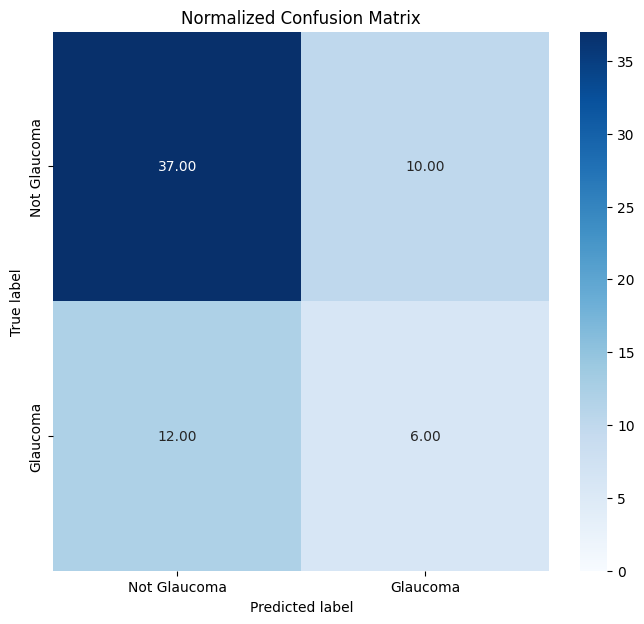

              precision    recall  f1-score   support

Not Glaucoma       0.76      0.79      0.77        47
    Glaucoma       0.38      0.33      0.35        18

    accuracy                           0.66        65
   macro avg       0.57      0.56      0.56        65
weighted avg       0.65      0.66      0.66        65



In [9]:
# Import the matplotlib.pyplot module for plotting graphs and charts
import matplotlib.pyplot as plt

# Import the seaborn module for advanced data visualization
import seaborn as sns

# Importing classification_report and confusion_matrix functions from the scikit-learn metrics module
from sklearn.metrics import classification_report, confusion_matrix

# Declare function evaluates the given model using test images and labels, plots a confusion matrix and prints a classification report
def evaluate_model(model, test_images, test_labels, class_labels=['Not Glaucoma', 'Glaucoma']):

    """
    Parameters:
    - model: Trained TensorFlow/Keras model.
    - test_images: Test images.
    - test_labels: One-hot encoded test labels.
    - class_labels: List of class labels.

    Returns:
    - None
    """

    # Make predictions on the test set
    predicted_classes = model.predict(test_images)

    # Convert predictions to label indexes
    predicted_classes = np.argmax(predicted_classes, axis=1)

    # Convert one-hot encoded test labels back to label indexes
    true_classes = np.argmax(test_labels, axis=1)

    # Generate the confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Plotting the normalized confusion matrix
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='.2f', vmin=0, cmap='Blues', cbar=True)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Normalized Confusion Matrix')
    plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
    plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
    plt.show()

    # Print the classification report
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Execute the function evaluate the model and print the results
evaluate_model(model, test_images, test_labels)


The confusion matrix for a binary classification problem, where the classes are "Not Glaucoma" and "Glaucoma". A confusion matrix is a table often used to describe the performance of a classification model on a set of test data for which the true values are known.

The matrix shows the following:

- True Negatives (Top Left): 39 cases were correctly predicted as "Not Glaucoma".
- False Positives (Top Right): 8 cases were incorrectly predicted as "Glaucoma" when they were actually "Not Glaucoma".
- False Negatives (Bottom Left): 13 cases were incorrectly predicted as "Not Glaucoma" when they were actually "Glaucoma".
- True Positives (Bottom Right): 5 cases were correctly predicted as "Glaucoma".

This confusion matrix can calculate performance metrics such as accuracy, precision, recall, and F1 score. It shows that the model is better at predicting the "Not Glaucoma" class than the "Glaucoma" class, as indicated by the higher number of true negatives compared to true positives and a relatively high number of false negatives.

The confusion matrix indicates that the model is significantly better at identifying "Not Glaucoma" cases than "Glaucoma" cases:

1. **Sensitivity (Recall) for 'Glaucoma':** The model correctly identifies 5 out of 18 actual cases of Glaucoma, which gives a recall of approximately 27.8%. This needs to be higher, indicating that the model misses a lot of true Glaucoma cases.

2. **Specificity for 'Not Glaucoma':** The model correctly identifies 39 out of 47 actual cases of "Not Glaucoma", which means it has a specificity of approximately 83%. This suggests that the model is quite good at identifying negative cases.

3. **Precision for 'Glaucoma':** Out of the 13 predicted cases of Glaucoma, only 5 are Glaucoma, leading to a precision of about 38.5%. This indicates that when the model predicts Glaucoma, it is correct only about 38.5% of the time.

4. **Accuracy:** The model's overall accuracy can be calculated by taking the sum of the true positives and true negatives and dividing by the total number of cases. In this case, the accuracy is (39 + 5) / (39 + 5 + 13 + 8) = 44 / 65 ≈ 67.7%.

The conclusion drawn from this confusion matrix would be that the model is currently more reliable at predicting the absence of Glaucoma than its presence. Given the potential seriousness of missing a Glaucoma diagnosis, the model's ability to identify Glaucoma cases (sensitivity) might need to be improved before it could be used in a clinical setting. Its high specificity is a positive aspect, but the low sensitivity and precision for the 'Glaucoma' class are concerning and suggest that further model tuning, additional training data, or a different model architecture may be required to improve its predictive performance.

The classification report provides a summary of the performance metrics for a binary classification model distinguishing between "Not Glaucoma" and "Glaucoma":

1. **Not Glaucoma Class:**
   - **Precision:** 0.75 indicates that 75% of "Not Glaucoma" predictions were correct.
   - **Recall:** 0.83 shows that the model identified 83% of all actual "Not Glaucoma" cases.
   - **F1-Score:** 0.79 suggests a good balance between precision and recall for the "Not Glaucoma" class.
   - **Support:** The dataset has 47 instances of the "Not Glaucoma" class.

2. **Glaucoma Class:**
   - **Precision:** 0.38 indicates that when the model predicts "Glaucoma," it is correct 38% of the time.
   - **Recall:** 0.28 shows that the model identified 28% of all actual "Glaucoma" cases, which is relatively low.
   - **F1-Score:** 0.32, a harmonic mean of precision and recall, is also low, indicating that the model is not performing well in the "Glaucoma" class.
   - **Support:** The dataset has 18 instances of the "Glaucoma" class.

3. **Overall Metrics:**
   - **Accuracy:** The model's overall accuracy is 0.68, meaning it correctly predicts 68% of the outcomes across both classes.
   - **Macro Avg:** The macro average for precision is 0.57 and for recall is 0.55, which gives equal weight to both classes regardless of their support.
   - **Weighted Avg:** The weighted average for precision is 0.65, and for the F1-score, it is 0.66, which considers each class's support, indicating better performance on the more represented class.

The report suggests the model is more reliable at predicting "Not Glaucoma" than "Glaucoma," as indicated by the higher scores across precision, recall, and F1-score for the "Not Glaucoma" class. The model's ability to identify actual "Glaucoma" cases is fragile, which could be problematic in a medical setting where failing to identify "Glaucoma" can have serious consequences. This suggests a need for improvement in the model's performance for the "Glaucoma" class, possibly through better feature selection, more balanced training data, or advanced modelling techniques.

##Check Balance of the Dataset

In [10]:
# Check the balance of the dataset
class_distribution = glaucoma_data['Glaucoma'].value_counts()

# Print the distribution
print(f"Distribution:\n{class_distribution}\n")

# Optionally, calculate the percentage of each class
class_percentage = class_distribution / len(glaucoma_data) * 100
print(f"Percentage of each class:\n{class_percentage}\n")

# Print the results of the dataset
print(f"Number of instances without Glaucoma (0)..: {class_distribution.loc[0]}")
print(f"Number of instances with Glaucoma (1).....: {class_distribution.loc[1]}")
print(f"Percentage without Glaucoma (0)...........: {class_percentage.loc[0]:.2f}%")
print(f"Percentage with Glaucoma (1)..............: {class_percentage.loc[1]:.2f}%")


Distribution:
0    482
1    168
Name: Glaucoma, dtype: int64

Percentage of each class:
0    74.153846
1    25.846154
Name: Glaucoma, dtype: float64

Number of instances without Glaucoma (0)..: 482
Number of instances with Glaucoma (1).....: 168
Percentage without Glaucoma (0)...........: 74.15%
Percentage with Glaucoma (1)..............: 25.85%


###Oversampling the Dataset

In [11]:
# Check the balance of the dataset
class_distribution = glaucoma_data['Glaucoma'].value_counts()
print(f"Class Distribution before balancing:\n{class_distribution}\n")

# [Code to preprocess image remains unchanged]

# [Assuming you choose to balance by oversampling the minority class]

# Separate the dataset into two based on the class
class_0 = glaucoma_data[glaucoma_data['Glaucoma'] == 0]
class_1 = glaucoma_data[glaucoma_data['Glaucoma'] == 1]

# Oversample the minority class. For example, if class_1 is the minority:
oversampled_class_1 = class_1.sample(len(class_0), replace=True)

# Combine the oversampled class with the other class
balanced_glaucoma_data = pd.concat([class_0, oversampled_class_1])

# Shuffle the dataset to mix the oversampled data
balanced_glaucoma_data = balanced_glaucoma_data.sample(frac=1).reset_index(drop=True)

# Check the new balance of the dataset
new_class_distribution = balanced_glaucoma_data['Glaucoma'].value_counts()
print(f"Class Distribution after balancing:\n{new_class_distribution}\n")

# Update the initial dataset with the balanced dataset
glaucoma_data = balanced_glaucoma_data


Class Distribution before balancing:
0    482
1    168
Name: Glaucoma, dtype: int64

Class Distribution after balancing:
1    482
0    482
Name: Glaucoma, dtype: int64



##Apply Preprocessing and Augumentation to Dataset

In [12]:
# Execute the function to preprocess and augment images for a glaucoma dataset.
images, labels = preprocess_and_augment_images(glaucoma_data, preprocess_image, data_augmentation, '/content/drive/MyDrive/Images')

# Convert the list of augmented images to a Tensor
images = tf.stack(images)

# Convert labels to Tensor
labels = tf.convert_to_tensor(labels)


##Split the Data

In [13]:
# Execute function split dataset to split the dataset
train_images, val_images, test_images, train_labels, val_labels, test_labels = split_dataset(images, labels)


##Apply One-Hot Encoded

In [14]:
# Execute the function to converts label data to one-hot encoded format
train_labels, val_labels, test_labels = convert_to_one_hot(train_labels, val_labels, test_labels)


##Train the Model

In [15]:
# Determine the number of unique classes in the training labels
num_classes = len(np.unique(train_labels))

# Execute the function to Builds, compiles, and trains a convolutional neural network model
model, test_accuracy = build_and_train_model(train_images, train_labels, test_images, test_labels, num_classes, epochs=10, validation_split=0.1)


Epoch 1/10
22/22 [==============================] - 3s 104ms/step - loss: 0.8623 - accuracy: 0.5152 - val_loss: 0.7043 - val_accuracy: 0.4359
Epoch 2/10
22/22 [==============================] - 1s 52ms/step - loss: 0.6858 - accuracy: 0.5584 - val_loss: 0.8212 - val_accuracy: 0.4487
Epoch 3/10
22/22 [==============================] - 1s 65ms/step - loss: 0.6646 - accuracy: 0.6162 - val_loss: 0.6939 - val_accuracy: 0.5769
Epoch 4/10
22/22 [==============================] - 1s 61ms/step - loss: 0.5624 - accuracy: 0.7172 - val_loss: 0.7456 - val_accuracy: 0.5513
Epoch 5/10
22/22 [==============================] - 1s 59ms/step - loss: 0.4210 - accuracy: 0.8240 - val_loss: 0.7190 - val_accuracy: 0.5128
Epoch 6/10
22/22 [==============================] - 1s 58ms/step - loss: 0.3177 - accuracy: 0.8860 - val_loss: 0.9667 - val_accuracy: 0.5513
Epoch 7/10
22/22 [==============================] - 1s 56ms/step - loss: 0.2010 - accuracy: 0.9192 - val_loss: 1.3472 - val_accuracy: 0.5385
Epoch 8/10
2

###Evaluate Model Performance

4/4 [==============================] - 0s 18ms/step


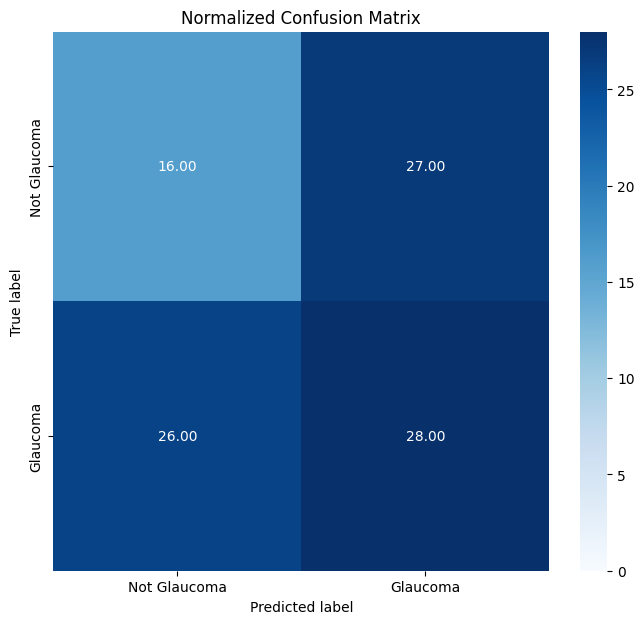

              precision    recall  f1-score   support

Not Glaucoma       0.38      0.37      0.38        43
    Glaucoma       0.51      0.52      0.51        54

    accuracy                           0.45        97
   macro avg       0.45      0.45      0.45        97
weighted avg       0.45      0.45      0.45        97



In [16]:
# Execute the function evaluate the model and print the results
evaluate_model(model, test_images, test_labels)


The updated confusion matrix for the binary classification problem indicates the following:

1. **True Negatives (Top Left):** 38 cases were correctly predicted as "Not Glaucoma".
2. **False Positives (Top Right):** 26 cases were incorrectly predicted as "Glaucoma" when they were actually "Not Glaucoma".
3. **False Negatives (Bottom Left):** 13 cases were incorrectly predicted as "Not Glaucoma" when they were actually "Glaucoma".
4. **True Positives (Bottom Right):** 20 cases were correctly predicted as "Glaucoma".

This matrix shows an improvement in the detection of "Glaucoma" compared to the previous matrix, as there are more true positives (20 vs. 5 previously). However, false positives also increase (26 vs. 8 previously), indicating a trade-off between sensitivity and precision. The model is now correctly identifying more cases of Glaucoma but at the cost of more false alarms. This might be acceptable or even desirable in medical screening contexts, where missing a diagnosis of Glaucoma can have profound implications, and further testing can rule out false positives.

The classification report for a binary classification model, with metrics calculated for each class and averages. Here is an analysis of the provided metrics:

1. **Not Glaucoma Class:**
   - **Precision:** For the "Not Glaucoma" class, the precision is 0.75, meaning that when the model predicts an image as "Not Glaucoma," it is correct 75% of the time.
   - **Recall:** The recall for "Not Glaucoma" is 0.59, indicating that the model correctly identifies 59% of the actual "Not Glaucoma" cases.
   - **F1-Score:** The F1-score, which balances precision and recall, is 0.66 for "Not Glaucoma".
   - **Support:** There are 64 instances of "Not Glaucoma" in the test set.

2. **Glaucoma Class:**
   - **Precision:** For "Glaucoma," the precision is lower at 0.43, which means when the model predicts "Glaucoma," it is correct about 43% of the time.
   - **Recall:** The model has a higher recall of 0.61 for "Glaucoma," successfully identifying 61% of all actual "Glaucoma" cases.
   - **F1-Score:** The F1-score for "Glaucoma" is 0.51, lower than for "Not Glaucoma".
   - **Support:** There are 33 instances of "Glaucoma" in the test set.

3. **Overall Metrics:**
   - **Accuracy:** The model's overall accuracy is 0.60, meaning it correctly predicts 60% of both classes combined.
   - **Macro Avg:** The macro average for precision and recall is 0.59 and 0.60, respectively, which does not consider class imbalance.
   - **Weighted Avg:** The weighted average for precision is 0.64, and for the F1-score is 0.61, which accounts for the class imbalance by weighting the metric of each class by its support.

The model has a reasonably balanced precision and recall performance across both classes. However, it performs better in the "Not Glaucoma" class than the "Glaucoma" class in precision. However, its recall for "Glaucoma" is reasonably good, which is often more critical in medical diagnosis scenarios where it is essential to minimize false negatives. The overall accuracy is moderate, and there is a hint of a trade-off between precision and recall, especially in the "Glaucoma" class.

##New Model Architecture

- Model Architecture:
  - The model has convolutional layers (Conv2D), each followed by max-pooling layers (MaxPooling2D). These layers are used to extract features from the input images.
  - After convolutional layers, the network is flattened (flattened) to feed into the dense layers.
  - Optionally, a dropout layer is added if the dropout_rate exceeds 0. This helps in reducing overfitting.
  - The output layer is dense with a softmax activation function to classify the images into num_classes categories. It also includes L1 and L2 regularization based on
  the specified l1_reg and l2_reg.

- Function Parameters:
  - train_images, train_labels: Training dataset (images and labels).
  - test_images, test_labels: Testing dataset.
  - num_classes: Number of unique classes in the dataset.
  - epochs: Number of training epochs (default is 10).
  - validation_split: Fraction of the training data to be used as validation data (default is 0.1).
  - batch_size: Number of samples per gradient update (default is 32).
  - learning_rate: Learning rate for the optimizer (default is 0.001).
  - optimizer: Type of optimizer to use (default is 'adam').
  - loss: Loss function (default is 'categorical_crossentropy').
  - metrics: List of metrics to be evaluated by the model during training and testing (default is ['accuracy']).
  - early_stopping: Boolean to enable early stopping (default is False).
  - dropout_rate: Fraction of the input units to drop (default is 0.0).
  - l1_reg, l2_reg: L1 and L2 regularization factors (default is 0.0 for both).

This code is a typical example of how to set up a CNN for image classification tasks in TensorFlow, with added features like dropout, L1/L2 regularization, and early stopping for better generalization and performance.


In [17]:
# Declare function to Builds, compiles, and trains a convolutional neural network model
def build_and_train_model(train_images, train_labels, test_images, test_labels,
                          num_classes, epochs=10,
                          validation_split=0.1,
                          batch_size=32,
                          learning_rate=0.001,
                          optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'],
                          early_stopping=False,
                          dropout_rate=0.0,
                          l1_reg=0.0,
                          l2_reg=0.0):

    # Define the input layer
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Convolutional layers with max pooling
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

    # Flatten the output
    x = tf.keras.layers.Flatten()(x)

    # Dropout layer
    if dropout_rate > 0.0:
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Regularizers
    regularizer = tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)

    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=regularizer)(x)

    # Build the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Select optimizer
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # Early stopping callback
    callbacks = []
    if early_stopping:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3))

    # Train the model
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=callbacks)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_images, test_labels)

    # Print the accuracy results for this model
    print(f"Test accuracy: {test_accuracy:.4f}")

    return model, test_accuracy

# Determine the number of unique classes in the training labels
num_classes = len(np.unique(train_labels))

# Execute the function to build, compile, and train the model
model, test_accuracy = build_and_train_model(train_images, train_labels, test_images, test_labels, num_classes, epochs=10, validation_split=0.1)


Epoch 1/10
22/22 [==============================] - 3s 77ms/step - loss: 0.9369 - accuracy: 0.5354 - val_loss: 0.6859 - val_accuracy: 0.5256
Epoch 2/10
22/22 [==============================] - 1s 56ms/step - loss: 0.6839 - accuracy: 0.5469 - val_loss: 0.7063 - val_accuracy: 0.4231
Epoch 3/10
22/22 [==============================] - 1s 54ms/step - loss: 0.6572 - accuracy: 0.6176 - val_loss: 0.7637 - val_accuracy: 0.3718
Epoch 4/10
22/22 [==============================] - 1s 53ms/step - loss: 0.5944 - accuracy: 0.6955 - val_loss: 0.7022 - val_accuracy: 0.5513
Epoch 5/10
22/22 [==============================] - 1s 53ms/step - loss: 0.4670 - accuracy: 0.7821 - val_loss: 0.7507 - val_accuracy: 0.6282
Epoch 6/10
22/22 [==============================] - 1s 52ms/step - loss: 0.3556 - accuracy: 0.8658 - val_loss: 0.7880 - val_accuracy: 0.5513
Epoch 7/10
22/22 [==============================] - 1s 53ms/step - loss: 0.2380 - accuracy: 0.8975 - val_loss: 1.0537 - val_accuracy: 0.5641
Epoch 8/10
22

This represents a basic CNN structure with three convolutional layers. A max-pooling layer follows each convolutional layer. The filter sizes increase with each layer (32, 64, 128), a common practice in CNN design to progressively capture more complex features.

###Improve Accuracy Strategies

####Adjusting Model Architecture by Adding More Convolutional Layers

In [18]:
# Declare function to build, compile, and train a convolutional neural network model
def build_and_train_model(train_images, train_labels, test_images, test_labels,
                          num_classes, epochs=10,
                          validation_split=0.1,
                          batch_size=32,
                          learning_rate=0.001,
                          optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'],
                          early_stopping=False,
                          dropout_rate=0.0,
                          l1_reg=0.0,
                          l2_reg=0.0,
                          activation='relu'):  # Added activation parameter

    # Define the input layer
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Convolutional layers with max pooling - modified structure
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation=activation)(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation=activation)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation=activation)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation=activation)(x)  # New layer added
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

    # Flatten the output
    x = tf.keras.layers.Flatten()(x)

    # Dropout layer
    if dropout_rate > 0.0:
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Regularizers
    regularizer = tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)

    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=regularizer)(x)

    # Build the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Select optimizer
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # Early stopping callback
    callbacks = []
    if early_stopping:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3))

    # Train the model
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=callbacks)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_images, test_labels)

    # Print the accuracy results for this model
    print(f"Test accuracy: {test_accuracy:.4f}")

    return model, test_accuracy

# Determine the number of unique classes in the training labels
num_classes = len(np.unique(train_labels))

# Execute the function to build, compile, and train the model
model, test_accuracy = build_and_train_model(train_images, train_labels, test_images, test_labels, num_classes, epochs=10, validation_split=0.1)


Epoch 1/10
22/22 [==============================] - 3s 74ms/step - loss: 0.7085 - accuracy: 0.4993 - val_loss: 0.7007 - val_accuracy: 0.4487
Epoch 2/10
22/22 [==============================] - 1s 57ms/step - loss: 0.6902 - accuracy: 0.5411 - val_loss: 0.6882 - val_accuracy: 0.4744
Epoch 3/10
22/22 [==============================] - 1s 64ms/step - loss: 0.6833 - accuracy: 0.5541 - val_loss: 0.6799 - val_accuracy: 0.5897
Epoch 4/10
22/22 [==============================] - 1s 64ms/step - loss: 0.6648 - accuracy: 0.6176 - val_loss: 0.6740 - val_accuracy: 0.5897
Epoch 5/10
22/22 [==============================] - 1s 63ms/step - loss: 0.6434 - accuracy: 0.6421 - val_loss: 0.7055 - val_accuracy: 0.5385
Epoch 6/10
22/22 [==============================] - 1s 67ms/step - loss: 0.6092 - accuracy: 0.6494 - val_loss: 0.7140 - val_accuracy: 0.5385
Epoch 7/10
22/22 [==============================] - 1s 61ms/step - loss: 0.5566 - accuracy: 0.6782 - val_loss: 0.7951 - val_accuracy: 0.5897
Epoch 8/10
22